# Audio Filter

Last python session of this course combining:

- OPAMP
- dynamic circuit
- filters
- phasor analysis
- transfer funcion 
- Bode diagram 
- Fundamental Theorem of the Sinusoidal Steady State
- SPICE AC simulation
- SPICE transient simulation 
- Fourier analysis (Discrete Fourier Transform)

## Goal:

Design an active lowpass filter for audio application (i.e., 0Hz to 20kHz), such that:

<img src="H-filter_schem.jpeg" width ="500" height=500>

where:
- $f_c=300\,$Hz;
- $A_{dB}=6\,$dBV in the bandpass.

1. Build a numerical version of the filter; 
2. Build a second order OPAMP filter with the above specifications. 

The filter performance should be evaluated by using the sample file "Ensoniq-ZR-76-08-Dope-92.wav" via both numerical e SPICE simulations.

In [1]:
import os
import ltspice
import matplotlib.pyplot as plt
import numpy as np
import math

#%matplotlib inline

#import mpld3
#mpld3.enable_notebook()

In [2]:
def my_IFFT(freq,Y):
    """Compute the time waveform y for the positive spectrum Y"""
    
    #sampling frequency
    fs = freq[2]-freq[1]
    
    y = np.fft.irfft(Y)
    
    N = len(y)
    
    time = np.linspace(0,1/fs,N)
    
    y = y*N/2
          
    return time,y

In [3]:
def my_FFT(time,y):
    """Compute the positive spectrum Y for the signal y"""
    
    #time step
    DT = time[1]-time[0]
    
    #number of samples
    N = len(y)
    
    Y = 2*np.fft.rfft(y,N)/len(y)

    freq = np.fft.rfftfreq(N,DT)
    
    return freq,Y

/var/folders/55/gzl8n7jn2mv7bl40sxjnb9f80000gn/T/ipykernel_17992/81988353.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data =  wavfile.read('Ensoniq-ZR-76-08-Dope-92.wav')


Text(0, 0.5, 'Amplitude [V]')

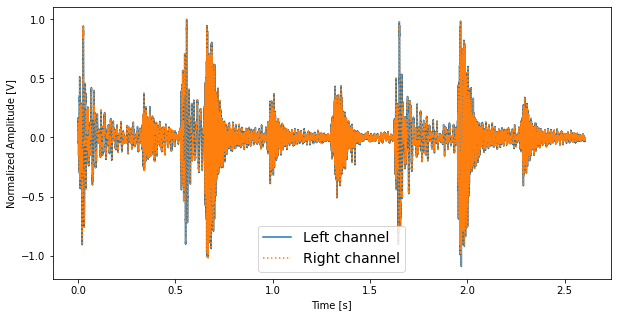

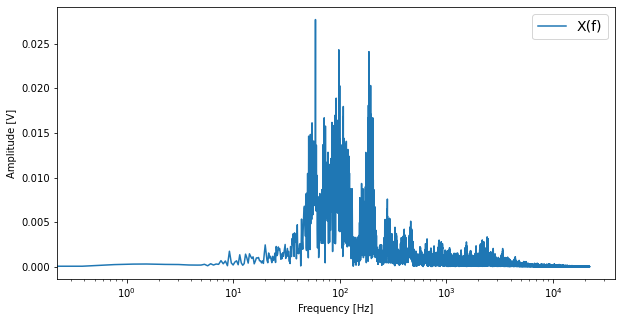

In [4]:
from scipy.io import wavfile
from scipy.io.wavfile import write as wavwrite


#read wav file
samplerate, data =  wavfile.read('Ensoniq-ZR-76-08-Dope-92.wav')


time_MAX = data.shape[0]/samplerate

time_wav = np.linspace(0,time_MAX,data.shape[0])

# plot the waverforms of the two channels
plt.figure(figsize=(10, 5))
plt.plot(time_wav, data[:, 0]/data[:,0].max(), label="Left channel")
plt.plot(time_wav, data[:, 1]/data[:,1].max(),':', label="Right channel")
plt.legend(loc="best",  scatterpoints=1, prop={'size': 14})
plt.xlabel("Time [s]")
plt.ylabel("Normalized Amplitude [V]")

x_wav = data[:,0].copy(order='C')

#normalize x 
x_wav = x_wav/x_wav.max()

x_wav_export = x_wav/x_wav.max()*2**15-1
wavwrite("test.wav",samplerate,x_wav_export.astype(np.int16))


#np.savetxt('prova.wav',data_txt,delimiter=' ')
freq_wav,X_wav = my_FFT(time_wav,x_wav)

plt.figure(figsize=(10, 5))
plt.semilogx(freq_wav,np.abs(X_wav),label="X(f)")
plt.legend(loc="best",  scatterpoints=1, prop={'size': 14})
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [V]")

In [5]:
# pip install simpleaudio

import simpleaudio as sa


# Ensure that highest value is in 16-bit range
x_wav_norm = x_wav * 2**15 - 1
# Convert to 16-bit data
x_wav_norm = x_wav_norm.astype(np.int16)


#x_wav_norm = x_wav_norm.copy(order='C')
# Start playback
play_obj = sa.play_buffer(x_wav_norm, 1, 2, samplerate)

# Wait for playback to finish before exiting
play_obj.wait_done()

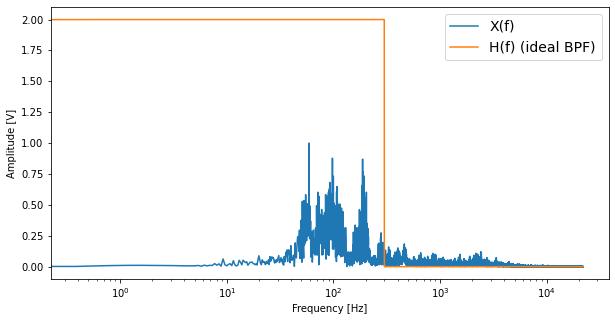

In [6]:
# IDEAL Bandpass filter

LF = 0
HF = 300

IDEAL_BPF= np.zeros(freq_wav.shape)

for ii in range(len(freq_wav)):
    if (freq_wav[ii]>LF) and (freq_wav[ii]<HF):
        IDEAL_BPF[ii] = 2
    else :
        IDEAL_BPF[ii] = 1e-30
        
plt.figure(figsize=(10, 5))
plt.semilogx(freq_wav,np.abs(X_wav)/np.max(np.abs(X_wav)),label='X(f)')
plt.semilogx(freq_wav,IDEAL_BPF,label='H(f) (ideal BPF)')
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [V]")
plt.legend(loc="best",  scatterpoints=1, prop={'size': 14})



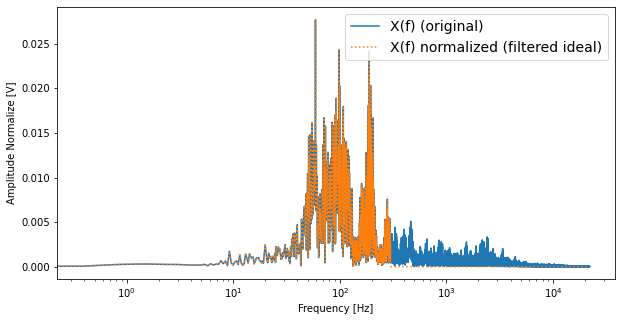

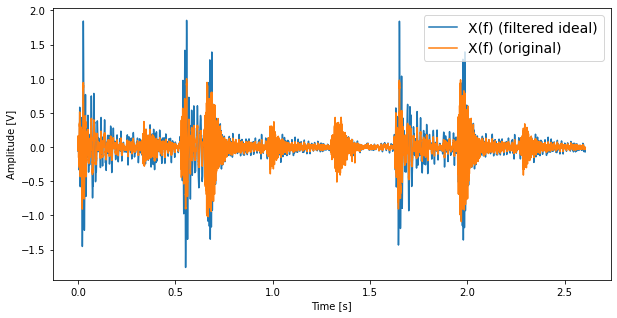

In [7]:
# filtered output

X_ideal_BPF_wav = X_wav*IDEAL_BPF

plt.figure(figsize=(10, 5))
plt.semilogx(freq_wav,np.abs(X_wav),label='X(f) (original)')
plt.semilogx(freq_wav,np.abs(X_ideal_BPF_wav)/2,':',label='X(f) normalized (filtered ideal)')

plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude Normalize [V]")
plt.legend(loc="best",  scatterpoints=1, prop={'size': 14})

# back to time
time_ideal_BPF_wav,x_ideal_BPF_wav = my_IFFT(freq_wav,X_ideal_BPF_wav)

plt.figure(figsize=(10, 5))
plt.plot(time_ideal_BPF_wav,x_ideal_BPF_wav,label='X(f) (filtered ideal)')
plt.plot(time_wav,x_wav,label='X(f) (original)')
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [V]")
plt.legend(loc="best",  scatterpoints=1, prop={'size': 14})


In [8]:
# let's hear the differences betweeen the two versions of the track

play_obj = sa.play_buffer(x_wav_norm, 1, 2, samplerate)

# Wait for playback to finish before exiting
play_obj.wait_done()


# Ensure that highest value is in 16-bit range
x_ideal_BPF_wav_norm = (x_ideal_BPF_wav * 2**15 - 1) / np.max(np.abs(x_ideal_BPF_wav))
# Convert to 16-bit data
x_ideal_BPF_wav_norm = x_ideal_BPF_wav_norm.astype(np.int16)


#x_wav_norm = x_wav_norm.copy(order='C')
# Start playback
play_obj = sa.play_buffer(x_ideal_BPF_wav_norm, 1, 2, samplerate)


# Wait for playback to finish before exiting
play_obj.wait_done()

## Design of a low pass OPAMP filter 

<img src="OPAMP-filter_schem.jpeg" width ="500" height=500>


$$H(j\omega)=\frac{X_F(j\omega)}{X(j\omega)}=-\dfrac{R_2}{R_1}\dfrac{1}{\left(1+j\omega L_1/R_1\right)\left(j\omega R_2 C_1\right)}$$

Two Poles: $p_1=-\frac{1}{L_1 R_1}$ and $p_2=-\frac{1}{C_1 R_2}$

We will consider the following values:

- $L_1 = 0.796\,$H
- $C_1 = 177\,$nF
- $R_1 = 1.5\,k\Omega$
- $R_2 = 3\,k\Omega$

## LTspice netlist and Python
**(file "AudioFilter_TF.cir")**

```
* Audio Filter - Transfer function

Vi 1 0 AC 1
R1 1 2 1.5k
L1 2 in_N 0.796

* call to the OPAMP model
XOA1 0 in_N out OPAMP

R2 in_N out 3k
C1 in_N out 177n

* Circuit analysis
.AC dec 1k 0.1 10Meg

*saving the data
.PRINT V(out)

* OPAMP equivalent
.SUBCKT OPAMP P N O
RI P N 2MEG
E1 1 0 P N 200k
Ro 1 O 75
.ENDS OPAMP

.END
```

In [9]:
import os
import ltspice
import math

import warnings
warnings.filterwarnings("ignore")


#Run the simulation and save in binary .raw
os.system('/Applications/LTspice.app/Contents/MacOS/LTspice -b AudioFilter_TF.cir')

0

In [10]:
#read the raw file generated by LTspice

filepath = 'AudioFilter_TF.raw'


l = ltspice.Ltspice(filepath)
l.parse() # Data loading sequence. It may take few minutes for huge file.

print(l.variables)

['frequency', 'V(out)']


In [11]:
var = l.variables

freq = l.get_frequency()

H_BPF = l.getData(var[1])

In [12]:
# Bode plot

H_BPF_dB = 20*np.log10(abs(H_BPF))

# analytical solution
L1 = 0.796
C1 = 177e-9
R1 = 1.5e3
R2 = 3e3


f_p1 = R1/(2*np.pi*L1)
f_p2 = 1/(2*np.pi*R2*C1)

jw = 1j*2*np.pi*freq
H_cf = -1/(L1*C1)/((jw+R1/(L1))*(jw+1/(R2*C1)))

H_BPF_analytical_dB = 20*np.log10(abs(H_cf))

print(f_p1)
print(f_p2)




299.9150937661344
299.72682314857883


Text(0.5, 1.0, 'Bode plot PHASE')

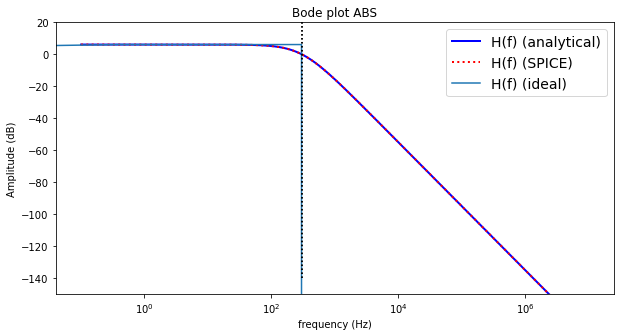

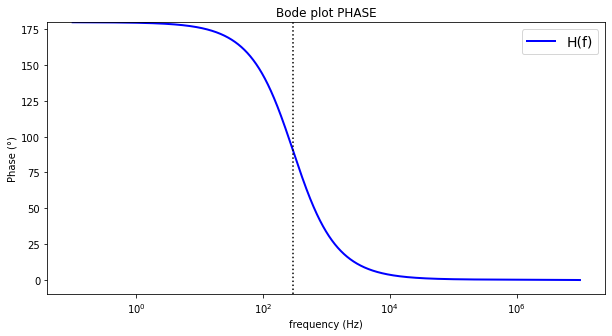

In [13]:
a = np.array
plt.figure(figsize=(10, 5))
plt.semilogx(freq,H_BPF_analytical_dB,color='blue',lw=2,label='H(f) (analytical)')
plt.semilogx(freq,H_BPF_dB,':',color='red',lw=2,label='H(f) (SPICE)')
plt.semilogx(freq_wav,20*np.log10(IDEAL_BPF),label='H(f) (ideal)')
plt.semilogx(np.array([f_p1,f_p1]),np.array([-140,25]),':k')
plt.semilogx(np.array([f_p2,f_p2]),np.array([-140,25]),':k')

plt.legend(loc="best",  scatterpoints=1, prop={'size': 14})
plt.xlabel('frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.title('Bode plot ABS')
plt.ylim([-150,20])

plt.figure(figsize=(10, 5))

plt.semilogx(freq,np.angle(H_BPF)*180/np.pi,color='blue',lw=2,label='H(f)')
#plt.semilogx(freq_wav,IDEAL_BPF*0*180/np.pi,label='H(f) (ideal BPF)')
plt.semilogx(np.array([f_p1,f_p1]),np.array([-10,180]),':k')

plt.ylim([-10,180])

plt.legend(loc="best",  scatterpoints=1, prop={'size': 14})
plt.xlabel('frequency (Hz)')
plt.ylabel('Phase (°)')
plt.title('Bode plot PHASE')

In [14]:
# Compute the filtered output by using the fundamental theorem

from scipy.interpolate import interp1d

H_abs_int = interp1d(freq, abs(H_BPF),fill_value='extrapolate')
H_phase_int = interp1d(freq,np.angle(H_BPF),fill_value='extrapolate')

X_BPF_wav = H_abs_int(freq_wav)*np.exp(1j*H_phase_int(freq_wav))*X_wav

# back to time
time_BPF_wav,x_BPF_wav = my_IFFT(freq_wav,X_BPF_wav)

Text(0, 0.5, 'Amplitude (V)')

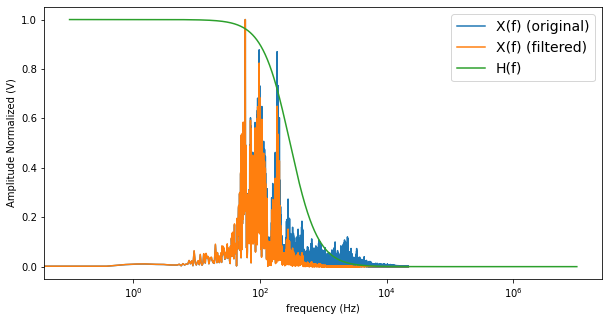

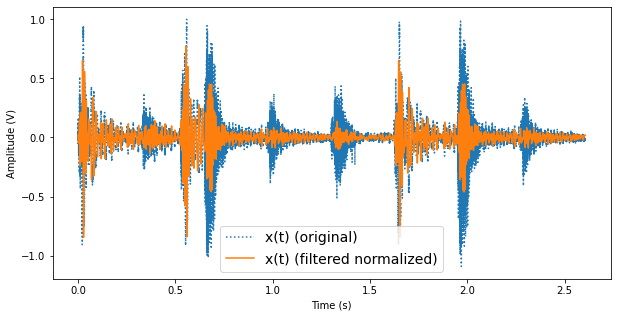

In [15]:
# plot
plt.figure(figsize=(10, 5))
plt.semilogx(freq_wav,np.abs(X_wav)/np.max(np.abs(X_wav)),label='X(f) (original)')
plt.semilogx(freq_wav,np.abs(X_BPF_wav)/np.max(np.abs(X_BPF_wav)),label='X(f) (filtered)')
plt.semilogx(freq,np.abs(H_BPF)/np.max(np.abs(H_BPF)),label='H(f)')
plt.legend(loc="best",  scatterpoints=1, prop={'size': 14})
plt.xlabel('frequency (Hz)')
plt.ylabel('Amplitude Normalized (V)')


plt.figure(figsize=(10, 5))
plt.plot(time_wav,x_wav,':',label='x(t) (original)')
plt.plot(time_BPF_wav,x_BPF_wav/2,label='x(t) (filtered normalized)' )

plt.legend(loc="best",  scatterpoints=1, prop={'size': 14})
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')

## LTspice netlist and Python
**(file "AudioFilter_tran.cir")**

```
* Audio Filter - Transient

Vi 1 0 wavefile="test.wav"
R1 1 2 1.5k
L1 2 in_N 0.796

* call to the OPAMP model
XOA1 0 in_N out OPAMP

R2 in_N out 3k
C1 in_N out 177n IC=0


* Circuit analysis
.tran 0 2.5 uic

*saving the data
.PRINT V(out)

* OPAMP equivalent
.SUBCKT OPAMP P N O
RI P N 2MEG
E1 1 0 P N 200k
Ro 1 O 75
.ENDS OPAMP

.END
```





In [16]:
# let's hear the differences betweeen the new filtered version of the track

play_obj = sa.play_buffer(x_wav_norm, 1, 2, samplerate)

# Wait for playback to finish before exiting
play_obj.wait_done()


# Ensure that highest value is in 16-bit range
x_BPF_wav_norm = (x_BPF_wav * 2**15 - 1) / np.max(np.abs(x_BPF_wav))
# Convert to 16-bit data
x_BPF_wav_norm = x_BPF_wav_norm.astype(np.int16)


#x_wav_norm = x_wav_norm.copy(order='C')
# Start playback
play_obj = sa.play_buffer(x_BPF_wav_norm, 1, 2, samplerate)


# Wait for playback to finish before exiting
play_obj.wait_done()

In [17]:
# read spice

#Run the simulation and save in binary .raw
os.system('/Applications/LTspice.app/Contents/MacOS/LTspice -b AudioFilter_tran.cir')


#read the raw file generated by LTspice

filepath = 'AudioFilter_tran.raw'


l = ltspice.Ltspice(filepath)
l.parse() # Data loading sequence. It may take few minutes for huge file.

time_SPICE = l.get_time()

x_BPF_SPICE = l.getData(var[1])



(-2.0, 2.0)

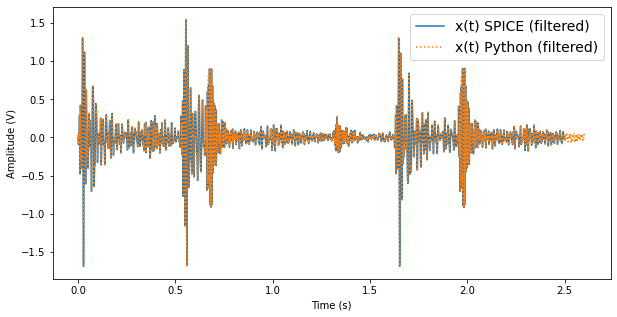

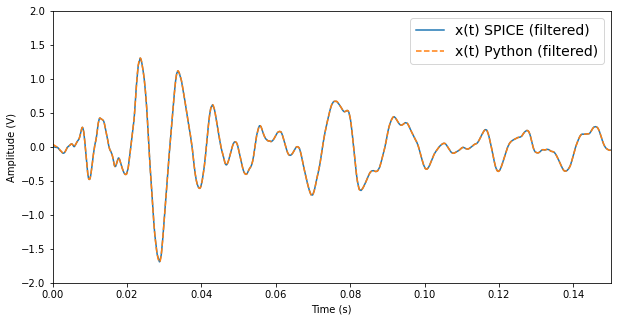

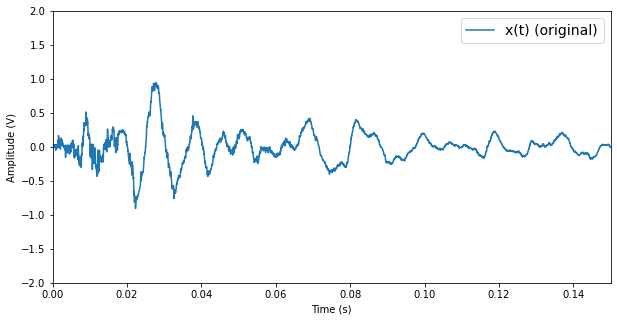

In [18]:
#Plots
plt.figure(figsize=(10, 5))
plt.plot(time_SPICE,x_BPF_SPICE,label='x(t) SPICE (filtered)')
plt.plot(time_BPF_wav,x_BPF_wav,':',label ='x(t) Python (filtered)')
#plt.plot(time_wav,x_wav,label='x(t) (original)')
plt.legend(loc="best",  scatterpoints=1, prop={'size': 14})
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')

plt.figure(figsize=(10, 5))
plt.plot(time_SPICE,x_BPF_SPICE,label='x(t) SPICE (filtered)')
plt.plot(time_BPF_wav,x_BPF_wav,'--',label ='x(t) Python (filtered)')
#plt.plot(time_wav,x_wav,label = 'x(t) (original)')
plt.legend(loc="best",  scatterpoints=1, prop={'size': 14})
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')

plt.xlim([0,0.15])
plt.ylim([-2,2])

plt.figure(figsize=(10, 5))
plt.plot(time_wav,x_wav,label = 'x(t) (original)')
plt.legend(loc="best",  scatterpoints=1, prop={'size': 14})
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')

plt.xlim([0,0.15])
plt.ylim([-2,2])